In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

In [ ]:
%cd /content/gdrive/MyDrive/chestct

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/chestct"

In [ ]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.57G/9.58G [01:25<00:00, 136MB/s]
100% 9.58G/9.58G [01:25<00:00, 120MB/s]


In [ ]:
!unzip /content/gdrive/MyDrive/chestct/chest-xray-masks-and-labels.zip

In [ ]:
!pip install -q mlflow


import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load  Dataset

In [ ]:
image_path_train = '/content/gdrive/MyDrive/chestct/Lung Segmentation/CXR_png/'
mask_path_train = '/content/gdrive/MyDrive/chestct/Lung Segmentation/masks/'
image_path_test = '/content/gdrive/MyDrive/chestct/Lung Segmentation/test/' 

In [ ]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [ ]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:", len(check))

Total mask that has modified name: 566


In [ ]:
testing_files = set(os.listdir(image_path_train)) & set(os.listdir(mask_path_train))
training_files = check

In [ ]:
def getData(X_shape, flag = "MONT"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "MONT":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "SHEN":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [ ]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, shape)
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

# Loading images and masks


In [ ]:
dim, n_samples = 256, 50 # n_samples = [1, 96]

image_shen, mask_shen = getData(dim, flag = "SHEN")
image_mont, mask_mont = getData(dim, flag = "MONT")
X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 50/50 [01:11<00:00,  1.42s/it]


In [ ]:
image_shen = np.array(image_shen).reshape(len(image_shen), dim, dim, 1)
mask_shen = np.array(mask_shen).reshape(len(mask_shen), dim, dim, 1)

image_mont = np.array(image_mont).reshape(len(image_mont), dim, dim, 1)
mask_mont = np.array(mask_mont).reshape(len(mask_mont), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

print(image_shen.shape, mask_shen.shape)
print(image_mont.shape, mask_mont.shape)
print(X_test.shape)

(566, 256, 256, 1) (566, 256, 256, 1)
(138, 256, 256, 1) (138, 256, 256, 1)
(50, 256, 256, 1)


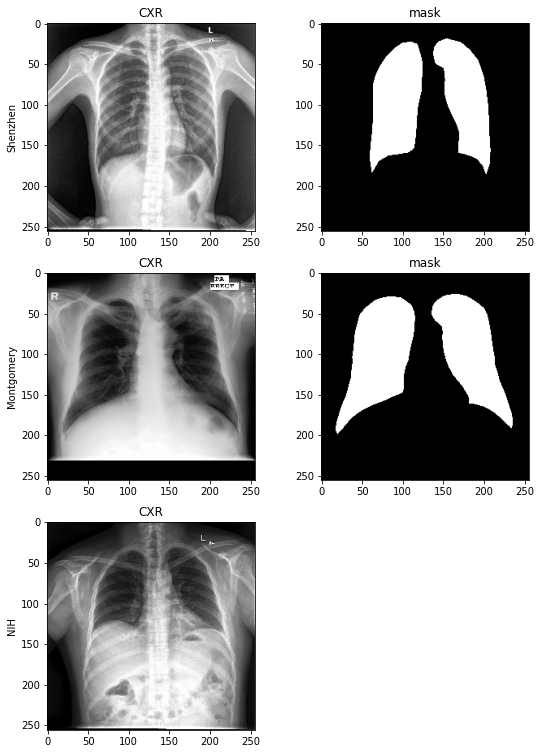

In [ ]:
i = 20
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(image_shen[i].reshape(256, 256), cmap='gray')
axs[0, 1].imshow(mask_shen[i].reshape(256, 256), cmap='gray')
axs[0, 0].set_ylabel('Shenzhen')

axs[1, 0].imshow(image_mont[i].reshape(256, 256), cmap='gray')
axs[1, 1].imshow(mask_mont[i].reshape(256, 256), cmap='gray')
axs[1, 0].set_ylabel('Montgomery')

axs[2, 0].imshow(X_test[i].reshape(256, 256), cmap='gray')
axs[2, 0].set_ylabel('NIH')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('mask')
axs[1, 1].set_title('mask')

fig.delaxes(axs[2, 1])

In [ ]:
assert image_shen.shape == mask_shen.shape
assert image_mont.shape == mask_mont.shape
images = np.concatenate((image_shen, image_mont), axis=0)
masks  = np.concatenate((mask_shen, mask_mont), axis=0)

print(images.shape, masks.shape)

(704, 256, 256, 1) (704, 256, 256, 1)


# Data Augmetation


In [ ]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255.0
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

def create_contrast_images_v1(b, c):
    contrast_images = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images.append(apply_brightness_contrast(images[i], brightness=b, contrast=c))
    return contrast_images

In [ ]:
b, c = -40, -120

contrast_images_v1 = create_contrast_images_v1(b, c)
contrast_images_v1 = np.array(contrast_images_v1).reshape(len(contrast_images_v1), 256, 256, 1)
print(f'\nshape = {contrast_images_v1.shape}')

contrast_images: 100%|██████████| 704/704 [00:00<00:00, 6635.93it/s]


shape = (704, 256, 256, 1)


In [ ]:
def create_contrast_images_v2(alpha, beta):
    contrast_images_v2 = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images_v2.append(cv2.addWeighted(images[i], alpha, images[i], 0, beta))
    return contrast_images_v2

In [ ]:
alpha = 1.5 #@alpha
beta = 0.7 #@beta

contrast_images_v2 = create_contrast_images_v2(alpha, beta)
contrast_images_v2 = np.array(contrast_images_v2).reshape(len(contrast_images_v2), 256, 256, 1)
print(f'\nshape = {contrast_images_v2.shape}')

contrast_images: 100%|██████████| 704/704 [00:00<00:00, 14611.26it/s]


shape = (704, 256, 256, 1)


In [ ]:
def noise(i: int = len(images)):
    return np.random.randint(0, 255, size=(i, 256, 256, 1))

def noise_images(epsilon: float = 0.1):
    noised = noise()
    noised_img = []
    for i in tqdm(range(len(images)), "noise_images"):
        noised_img.append(noised[i] * epsilon + images[i])
    
    return noised_img

noised_images = noise_images(epsilon=0.1)
noised_images = np.array(noised_images).reshape(len(noised_images), 256, 256, 1)
print(f'\nshape = {noised_images.shape}')

noise_images: 100%|██████████| 704/704 [00:00<00:00, 2326.65it/s]



shape = (704, 256, 256, 1)


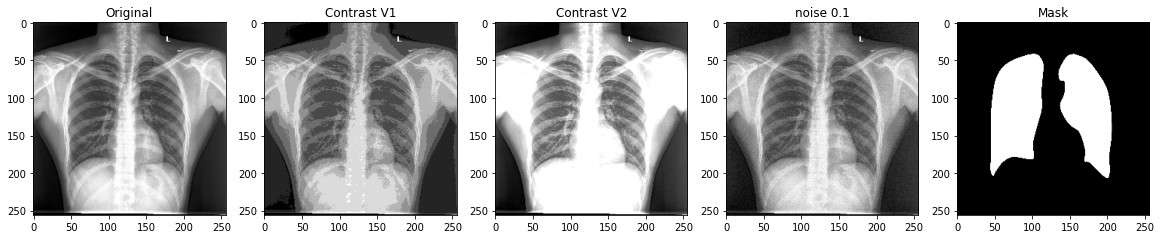

In [ ]:
i = 15
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))

ax1.imshow(images[i].reshape(256, 256), cmap='gray')
ax1.set_title('Original')

ax2.imshow(contrast_images_v1[i].reshape(256, 256), cmap='gray')
ax2.set_title('Contrast V1')

ax3.imshow(contrast_images_v2[i].reshape(256, 256), cmap='gray')
ax3.set_title('Contrast V2')

ax4.imshow(noised_images[i].reshape(256, 256), cmap='gray')
ax4.set_title('noise 0.1')

ax5.imshow(masks[i].reshape(256, 256), cmap='gray')
ax5.set_title('Mask');

In [ ]:
all_images = np.concatenate((images, contrast_images_v1, contrast_images_v2, noised_images), axis=0)
all_masks  = np.concatenate((masks, masks, masks, masks), axis=0)

all_images.shape, all_masks.shape


((2816, 256, 256, 1), (2816, 256, 256, 1))

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split((all_images - 127.0) / 127.0, 
                                                  (all_masks > 127).astype(np.float32), 
                                                  test_size = 0.2, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

# Residual U-Net


In [ ]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import mlflow
import mlflow.tensorflow

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [ ]:
def bn_act(x, act=True):
    x = tensorflow.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tensorflow.keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = tensorflow.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = tensorflow.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = tensorflow.keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
    c = tensorflow.keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = tensorflow.keras.layers.Input((dim, dim, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tensorflow.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tensorflow.keras.models.Model(inputs, outputs)
    return model

In [ ]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

In [ ]:
mlflow.autolog()


2022/05/21 06:16:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/05/21 06:16:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [ ]:
model = ResUNet()
adam = tensorflow.keras.optimizers.Adam()
model.compile(optimizer=adam, loss=loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

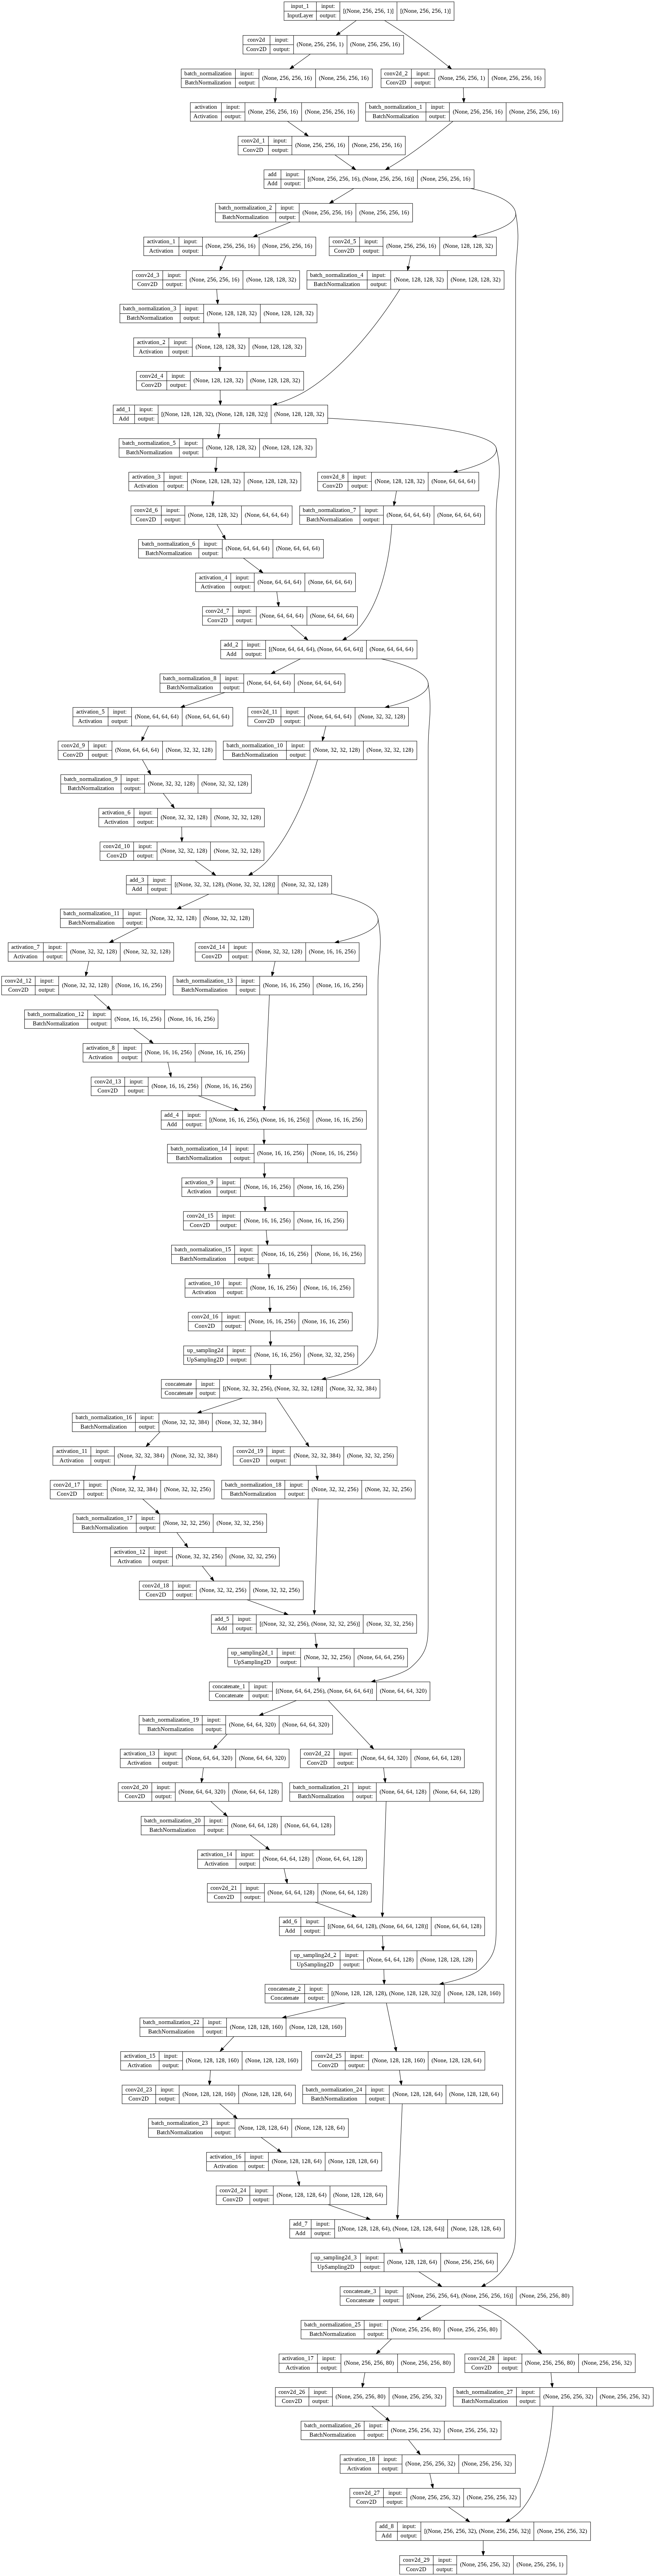

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
weight_path="{}_res_unet.h5".format('BEST')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

callbacks_list = [checkpoint, reduceLROnPlat]

In [ ]:
#initialize random seeds so results are repeatable
import random
import tensorflow as tf

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=32, epochs=50,
                callbacks=callbacks_list)

# plot model response

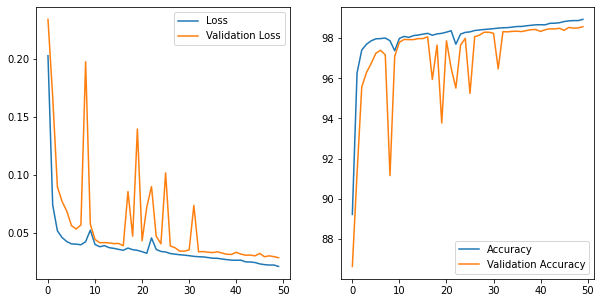

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

# Prediction on Validation set

In [ ]:
from keras.models import load_model
model=load_model(r"/content/gdrive/MyDrive/chestct/BEST_res_unet.h5", compile=False)

In [ ]:
preds_val = model.predict(X_val)


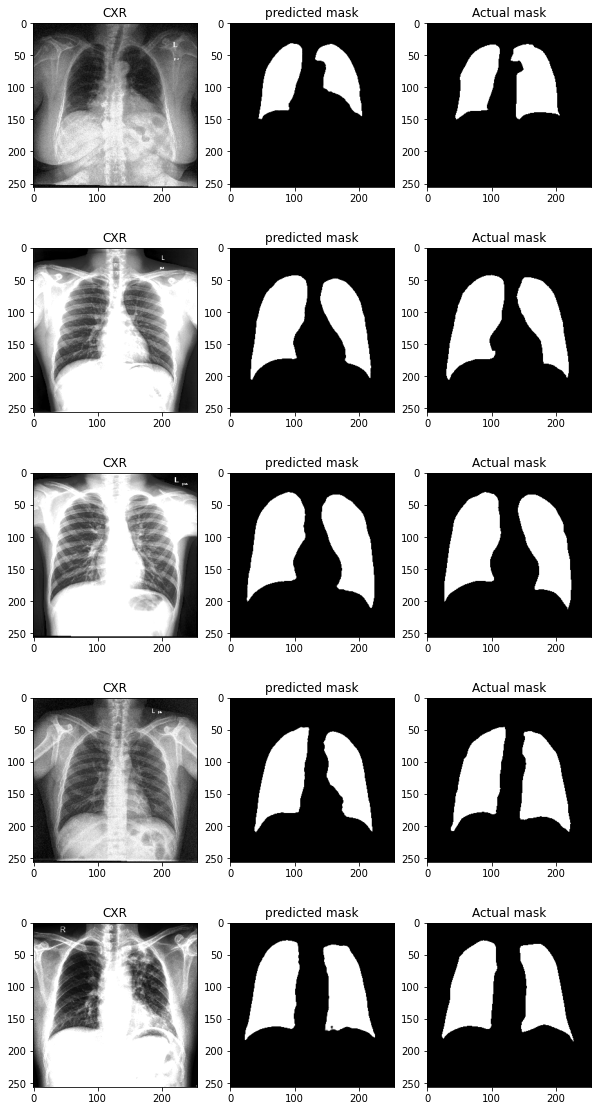

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for i in range(5):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('CXR')
        elif j == 1:
            axs[i, j].imshow(preds_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('predicted mask')
       
        elif j == 2:
            axs[i, j].imshow(Y_val[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('Actual mask')

In [ ]:
preds = model.predict(X_testNorm)


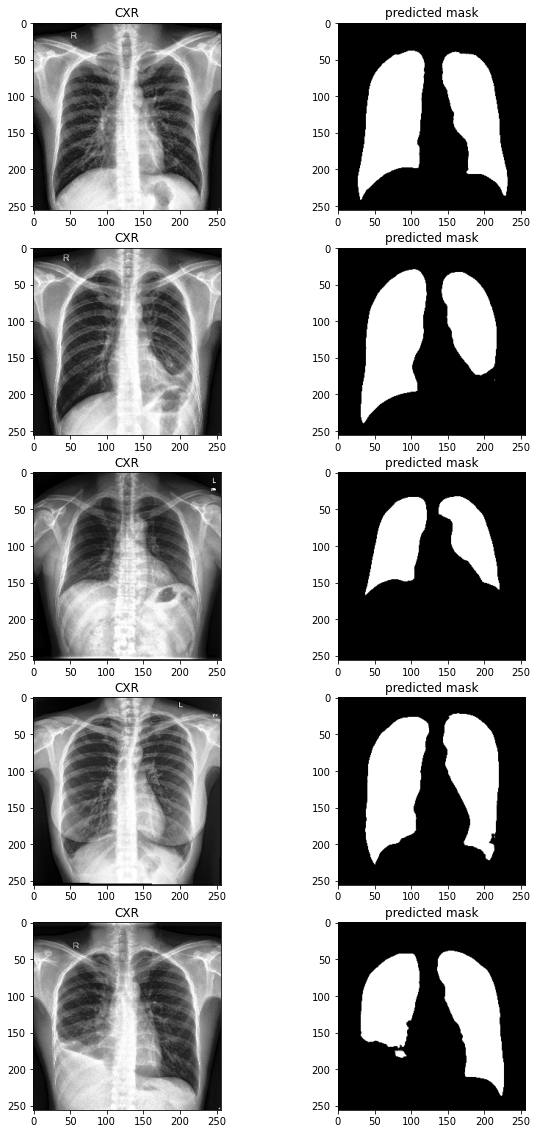

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(preds[i + 10].reshape(256, 256), cmap='gray')
            axs[i, j].set_title('predicted mask')